<a href="https://colab.research.google.com/github/Hevej/Machine-Learning/blob/main/NivelEducativo_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Conexión con Drive y Librerias

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import seaborn as sns
import pkg_resources
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
print(matplotlib.__version__)

3.2.2


In [ ]:
!python --version

Python 3.7.13


#Importar el DataFrame

In [ ]:
data = pd.read_pickle("/content/drive/MyDrive/SisbenColombia/Sisben.pkl")  

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3706298 entries, 0 to 3706297
Data columns (total 73 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   cod_mpio  int64 
 1   ZONA      int64 
 2   HOG001    int64 
 3   HOG002    int64 
 4   HOG003    int64 
 5   HOG004    int64 
 6   HOG005    int64 
 7   HOG006    int64 
 8   HOG007    int64 
 9   HOG008    int64 
 10  HOG009    int64 
 11  HOG010    int64 
 12  HOG011    int64 
 13  HOG012    int64 
 14  HOG013    int64 
 15  HOG014    int64 
 16  HOG015    int64 
 17  HOG016    int64 
 18  HOG017    int64 
 19  HOG018    int64 
 20  HOG019    int64 
 21  HOG020    int64 
 22  HOG021    int64 
 23  HOG022    int64 
 24  HOG023    int64 
 25  HOG024    int64 
 26  HOG025    int64 
 27  HOG026    int64 
 28  HOG027    int64 
 29  H_5       int64 
 30  I1        int64 
 31  I2        int64 
 32  I3        int64 
 33  I4        int64 
 34  I5        int64 
 35  I6        int64 
 36  I7        int64 
 37  I8        int64 
 38  I9

# Coorrelación

In [ ]:
numericas = ['VIV009', 'VIV010', 'HOG002', 'HOG003','HOG009', 'HOG011', 'HOG027', 'H_5']
nominales = ['I1','I2', 'I3', 'I4', 'I5', 'I6','I7', 'I8',
                        'I9', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15',
                        'cod_mpio', 'ZONA','VIV001','VIV002', 'VIV003', 'VIV004', 'VIV005',
                        'VIV006','VIV007', 'VIV008', 'HOG001', 'HOG004',
                        'HOG005','HOG006', 'HOG007', 'HOG008', 'HOG010', 'HOG012',
                        'HOG013', 'HOG014', 'HOG015', 'HOG016', 'HOG017', 'HOG018',
                        'HOG019', 'HOG020', 'HOG021', 'HOG022', 'HOG023', 'HOG024',
                        'HOG025', 'HOG026', 'PER001', 'PER002', 'PER003', 'PER004', 'PER005',
                        'PER006', 'PER007', 'PER011', 'PER012',
                        'PER013', 'PER014', 'PER015', 'PER016', 'PER017', 'PER018', 'PER019',
                        'PER020']

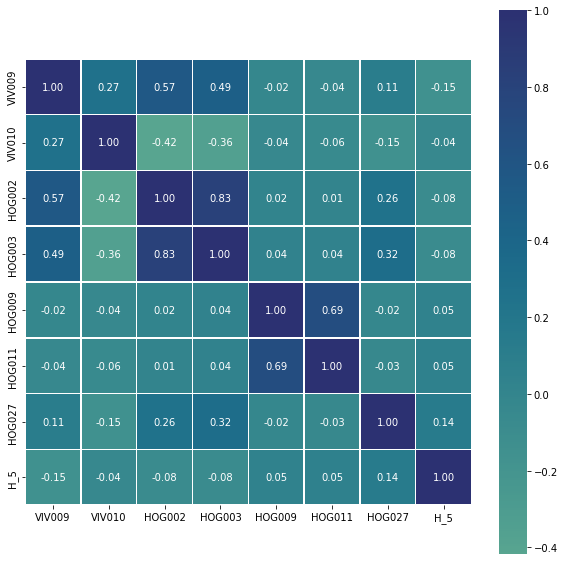

In [ ]:
#La correlación de Spearman se hace cuando las variables son al menos, ordinales.
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data[numericas].corr(method = 'spearman'), vmax=1.0, center=0,
            fmt='.2f', square=True, linewidths=.5, annot=True, cmap='crest')

Se considera una alta correlación por encima de 0.5 o por debajo de -0.5, en este caso tenemos que:
   * corr(VIV009:HOG002) = 0.57
    * Numero de cuartos vs cuartos exclusivos
   * corr(HOG009:HOG011) = 0.69
    * Dias en los que llega el agua vs cuantas horas llega el agua.

* corr(HOG002:HOG003) = 0.83
    * Cuartos exclusivos vs cuartos para dormir

Con estas medidas, decido borrar HOG002 y HOG011, un threshold de 0.7

In [ ]:
data.drop(['HOG002', 'HOG011'], axis=1, inplace=True)

Ahora se pasan las variables nominales a dummy mediante un one-hot encoding para poder realizar la comparación de correlación entre todas las variables del dataset.

La otra alternativas era Cramer's V, solo para las variables categoricas.

In [ ]:
encoding_data = pd.get_dummies(data, columns=nominales, drop_first=True)

In [ ]:
encoding_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3706298 entries, 0 to 3706297
Columns: 1273 entries, HOG003 to PER020_99
dtypes: int64(6), object(1), uint8(1266)
memory usage: 4.6+ GB


Como vemos, es muy dificil obtener un analisis por medio de Pearson, Spearman o Kendall, debido a que obtenemos 1273 columnas,al intentarlo, Colab no arroja un mensaje de uso maximo de RAM (50Gb en sesion de High-RAM). Por esta razón, se descarta la idea de hacer analisis de correlación de esta manera.

In [ ]:
import scipy.stats as ss
import numpy as np

Se define una función para calcular el coeficiente Cramer's V

In [ ]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

Se calculan los coeficientes para todas las variables nominales (categoricas)

In [ ]:
from itertools import product

In [ ]:
iter_list_columns_data = list(product(nominales, nominales))

In [ ]:
cr_v_c = dict()
for item in iter_list_columns_data:
  if item[0] != item[1]:
    cramers_v_coeff = cramers_corrected_stat(pd.crosstab(data[item[0]], data[item[1]]))
    if cramers_v_coeff > 0.5:
      cr_v_c[f'{item[0]}-{item[1]}'] = cramers_v_coeff

In [ ]:
len(cr_v_c.copy())

184

In [ ]:
cr_v_c_new = dict()
for key in cr_v_c:
  first_prop, second_prop = key.split('-')
  if not(f'{first_prop}-{second_prop}' in cr_v_c_new) and not(f'{second_prop}-{first_prop}' in cr_v_c_new):
    cr_v_c_new[key] = cr_v_c[key]

In [ ]:
lista = list(cr_v_c_new.items())

In [ ]:
sorted_by_second = sorted(lista, key=lambda tup: tup[1])

In [ ]:
for item in sorted_by_second:
  if item[1] >= 0.7:
    print(item)

('HOG007-HOG008', 0.7071054456878507)
('HOG007-HOG010', 0.7071054456878508)
('PER013-PER015', 0.7071054456878508)
('PER013-PER016', 0.7071054456878508)
('PER014-PER017', 0.7071063996157487)
('PER014-PER015', 0.7071065904011739)
('PER014-PER016', 0.7071065904011739)
('PER016-PER017', 0.7080950041787372)
('PER015-PER016', 0.7092008389075575)
('PER013-PER014', 0.7092612148548202)
('PER006-PER019', 0.7173532157922614)
('HOG005-HOG006', 0.72427898787252)
('I14-VIV002', 0.7360996974586578)
('HOG004-HOG005', 0.7455495681030394)
('PER003-PER004', 0.7476782138089241)
('PER002-PER006', 0.7480657012393231)
('PER001-PER011', 0.7523162590141843)
('I12-HOG004', 0.8259342297706601)
('I5-I9', 0.828378366690938)
('PER016-PER019', 0.828545718960249)
('HOG008-HOG010', 0.8318055249682179)
('I11-HOG008', 0.8471251720058687)
('I11-HOG010', 0.8471251720058687)
('PER002-PER016', 0.8558364784300457)
('PER001-PER012', 0.856812454382769)
('I11-VIV008', 0.8662503967702986)
('VIV001-HOG014', 0.8760760274624783)
('

Según la anterior lista, las correlaciones que superen un coeficiente de 0.7 son las que decidiran cuales estan altamente relacionadas.

Se eliminaran:
  * HOG008
  * HOG015
  * PER014
  * PER015
  * PER016
  * PER019
  * HOG006
  * I14
  * I5
  * I12
  * I11
  * I13
  * HOG005
  * PER004
  * PER006
  * PER011
  * PER012
  * HOG014
  * HOG010
  * VIV008
  * HOG017
  * HOG004
  * HOG013
  * PER005

In [ ]:
corr_delete_col = ['HOG008', 'HOG015', 'PER014', 'PER015', 'PER016','PER019', 'Grupo'
                   'HOG006', 'I14', 'I5', 'I12', 'I11', 'I13', 'HOG005', 'PER004', 'PER006',
                   'PER011', 'PER012', 'HOG014', 'HOG010', 'VIV008', 'HOG017', 'HOG004', 'HOG013', 'PER005']

In [ ]:
data.drop(corr_delete_col, axis=1, inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3706298 entries, 0 to 3706297
Data columns (total 47 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   cod_mpio  int64 
 1   ZONA      int64 
 2   HOG001    int64 
 3   HOG003    int64 
 4   HOG007    int64 
 5   HOG009    int64 
 6   HOG012    int64 
 7   HOG016    int64 
 8   HOG018    int64 
 9   HOG019    int64 
 10  HOG020    int64 
 11  HOG021    int64 
 12  HOG022    int64 
 13  HOG023    int64 
 14  HOG024    int64 
 15  HOG025    int64 
 16  HOG026    int64 
 17  HOG027    int64 
 18  H_5       int64 
 19  I1        int64 
 20  I2        int64 
 21  I3        int64 
 22  I4        int64 
 23  I6        int64 
 24  I7        int64 
 25  I8        int64 
 26  I9        int64 
 27  I10       int64 
 28  I15       int64 
 29  Grupo     object
 30  PER001    int64 
 31  PER002    int64 
 32  PER003    int64 
 33  PER007    int64 
 34  PER013    int64 
 35  PER017    int64 
 36  PER018    int64 
 37  PER020    int64 
 38  VI

In [ ]:
data.to_pickle("/content/drive/MyDrive/SisbenColombia/Sisben_correlacion.pkl") 

# Sets de Entrenamiento

In [ ]:
data = pd.read_pickle("/content/drive/MyDrive/SisbenColombia/Sisben_correlacion.pkl")  

In [ ]:
from sklearn.model_selection import train_test_split

data.drop('Grupo', axis=1, inplace = True)
X = data.loc[:, data.columns != 'PER017']
y = data['PER017']

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=20, random_state=0)

In [ ]:
model = clf.fit(train_x, train_y)

In [ ]:
model

RandomForestClassifier(n_estimators=20, random_state=0)

In [ ]:
y_pred = clf.predict(test_x)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
confusion_matrix(test_y, y_pred)

array([[ 49473,  31485,     46,      0],
       [ 20657, 516779,   8184,      0],
       [   158,  32451,  15801,      0],
       [     0,      0,      0,  66226]])

In [ ]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           1       0.70      0.61      0.65     81004
           2       0.89      0.95      0.92    545620
           3       0.66      0.33      0.44     48410
           9       1.00      1.00      1.00     66226

    accuracy                           0.87    741260
   macro avg       0.81      0.72      0.75    741260
weighted avg       0.86      0.87      0.86    741260



In [ ]:
accuracy_score(test_y, y_pred)

0.8745635809297683